<a href="https://colab.research.google.com/github/devansh-shah-11/Splitwise/blob/main/Copy_of_Transfer_Learning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning**


<img src="https://media.licdn.com/dms/image/C5612AQE8jRiwRCK4Lw/article-inline_image-shrink_1000_1488/0/1589803788079?e=1681948800&v=beta&t=FeO_YjNIfPDwNffCS8O8HduTz5xd7usTuQHYMOllo-Y" />

---


* Author: Hetul Patel
* Linekedin: https://www.linkedin.com/in/hetul-v-patel/


In [ ]:
!pip -q install ipyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00


## Utility Functions

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import math
import os
import numpy as np

def resize_and_show(image, desired_height=240, desired_width=240):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (desired_width, math.floor(h/(w/desired_width))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/desired_height)), desired_height))
  cv2_imshow(img)

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename="", quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture Image';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])

  if filename:
    dir = os.path.dirname(filename)
    os.makedirs(dir, exist_ok=True)
    with open(filename, "wb") as f:
      f.write(binary)

  image = cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)
  return image

# Capture Demo

In [ ]:
image = take_photo()

<IPython.core.display.Javascript object>

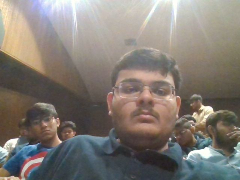

In [ ]:
resize_and_show(image)

# Capture Class Image

In [ ]:
class_1_name = "pen"
class_2_name = "specs"
class_3_name = "face"

## Capture Image for Class 1

In [ ]:
x = take_photo(filename=f"images/{class_1_name}/image_1.jpg")
resize_and_show(x)

<IPython.core.display.Javascript object>

In [ ]:
x = take_photo(filename=f"images/{class_1_name}/image_2.jpg")
resize_and_show(x)

In [ ]:
x = take_photo(filename=f"images/{class_1_name}/image_3.jpg")
resize_and_show(x)

## Capture Image for Class 2

In [ ]:
x = take_photo(filename=f"images/{class_2_name}/image_1.jpg")
resize_and_show(x)

In [ ]:
x = take_photo(filename=f"images/{class_2_name}/image_2.jpg")
resize_and_show(x)

In [ ]:
x = take_photo(filename=f"images/{class_2_name}/image_3.jpg")
resize_and_show(x)

## Capture Image for Class 3

In [ ]:
x = take_photo(filename=f"images/{class_3_name}/image_1.jpg")
resize_and_show(x)

In [ ]:
x = take_photo(filename=f"images/{class_3_name}/image_2.jpg")
resize_and_show(x)

In [ ]:
x = take_photo(filename=f"images/{class_3_name}/image_3.jpg")
resize_and_show(x)

# Synthetic Data Augmentation

In [ ]:
import albumentations as A
import random

In [ ]:
transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.GaussNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

In [ ]:
for i in range(3):
  augmented_image = transform(image=x)['image']
  resize_and_show(augmented_image)

In [ ]:
import glob
from tqdm import tqdm 

# Create Training/Validation Images By Augmenting captured Images
image_dir = "images"
all_classes = sorted(os.listdir(image_dir)) 
display_images = []

# Create augmented version of each image
for class_name in all_classes:
  # list images for given class
  images = sorted(os.listdir(os.path.join(image_dir, class_name)))
  cnt = 0
  for image_path in images:
    # read image from disk
    image = cv2.imread(os.path.join(image_dir, class_name, image_path))
    
    # save 10 augmentation for this image
    for i in tqdm(range(10), desc=f"{class_name}-{image_path}"):
      augmented_image = transform(image=image)['image']
      ouput_dir = "train" if cnt < 2 else "validation"
      ouput_dir = os.path.join(ouput_dir, class_name)
      os.makedirs(ouput_dir, exist_ok=True)
      cv2.imwrite(os.path.join(ouput_dir, f"aug_{i+1}_{image_path}"), augmented_image)

      if cnt >= 2:
        display_images.append(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    cnt+=1

In [ ]:
import ipyplot
ipyplot.plot_images(display_images, max_images=100, img_width=150)

# Data preprocessing

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
train_dir = "train"
validation_dir = "validation"
test_dir = "images"

BATCH_SIZE = 3
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                          shuffle=False,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

## Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    #flipping and rotating image every time image given to model
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Create the base model from scratch

First, instantiate a MobileNet V2 model with randomly initialized weights.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, #to avoid using la
                                               weights=None)

## Rescale pixel values

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Training Entire Model From Scratch

## Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Apply a tf.keras.layers.Dense layer to convert these features into a probability vector.


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

## Build Model

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

## Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

## Learning Curves

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


<img src="https://media.tenor.com/qkRQPFXAb5IAAAAd/the-office.gif" width=48%>


# Transfer Learning

<img src="https://media.tenor.com/sOb--NKJ64gAAAAC/challenge-accepted-himym.gif" width=50%>


# Create the base model from the pre-trained convnets

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

## Freeze the convolutional base

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

## Add a classification head

<img src="https://scontent.famd7-1.fna.fbcdn.net/v/t39.30808-6/265533741_2951920375137880_3990234937858485615_n.jpg?_nc_cat=106&ccb=1-7&_nc_sid=825194&_nc_ohc=sz4gSEZZCY4AX9EmT5c&_nc_ht=scontent.famd7-1.fna&oh=00_AfCGEDtzN2FKGVcRoEjK8ch6BK3InqQ5eXikXJcLkMNI3Q&oe=63FB6628" width=60%>

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

Apply a tf.keras.layers.Dense layer to convert these features into a probability vector.


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

## Build Model

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

## Why Trainable params = 3,843 ?

<img src="https://media.tenor.com/BMQTJ4nWvCIAAAAd/thinking-think.gif"  width="40%">

## Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

## Learning Curves

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<img src="https://media.tenor.com/t2-Zy0F7UYIAAAAC/akshay-kumar-gif.gif" />

# Fine tuning

<img src="https://media.tenor.com/bWkE0Y8JaBgAAAAC/dragon-ball-super-saiyan.gif">

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

* Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is.

* The first few layers learn very simple and generic features that generalize to almost all types of images. 

* As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. 

* The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

## Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Compile the model

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()


## Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.



In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<img src="https://media.tenor.com/xROfsR0oiNoAAAAC/shocked-joey.gif">

## Evaluation

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Prediction

In [ ]:
class_name_map = {
    0: class_1_name,
    1: class_2_name,
    2: class_3_name
}

def predict_image():

  # take photo
  image = take_photo()
  image_resized = tf.expand_dims(tf.image.resize(image, IMG_SIZE), axis=0)
  
  # predict class
  predictions = model.predict(image_resized).flatten()
  predictions = tf.nn.softmax(predictions)
  class_id = tf.argmax(predictions).numpy()
  class_score = predictions[class_id].numpy() * 100

  # show result
  resize_and_show(image, desired_width=640)
  print(f"\n\n{class_name_map[class_id]} (conf = {int(class_score)}%)")

In [ ]:
predict_image()

# Some Real World Projects Levaraging Transfer Learning.


1. Few Shot Learning
  * [On Device Detection](https://hetul-patel.github.io/projects/on_device_classification/)

2. Contrastive Learning
  * [Deep Face Recognition](https://hetul-patel.github.io/projects/deep_face_recognition/)

3. Self Supervised Learning
  * [Clothes Retrieval](https://hetul-patel.github.io/projects/clothes_retrieval/)

4. Curriculum Learning
  * [License Plate Recognition](https://hetul-patel.github.io/projects/alpr/)

5. Multitask Learning
  * [Face Detection and Face Landmark estimation](https://github.com/deepinsight/insightface/tree/master/detection/retinaface)

6. Unsupervised Domain Adaptation
  * [Digit Classification](https://medium.com/@2017csm1006/unsupervised-domain-adaptation-by-backpropagation-da730a190fd2)

7. Transfer Learning For NLP known as Pre Training
BERT
  * [Downstream text related tasks.](https://jalammar.github.io/illustrated-bert/)
